In [2]:
import json
import os
import dotenv

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from dialogue2graph import metrics
from dialogue2graph.pipelines.core.graph import Graph
from dialogue2graph.pipelines.model_storage import ModelStorage
from dialogue2graph.pipelines.helpers.parse_data import PipelineRawDataType

/home/peshkichev/miniconda3/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(


In [5]:
dotenv.load_dotenv()

True

In [6]:
ms = ModelStorage()

In [7]:
ms.add(
        key="grouping_llm",
        config={"model_name": "chatgpt-4o-latest", "temperature": 0},
        model_type="llm",
    )    
ms.add(
        key="extending_llm",
        config={"model_name": "chatgpt-4o-latest", "temperature": 0},
        model_type="llm",
    )    
ms.add(
        key="filling_llm",
        config={"model_name": "o3-mini", "temperature": 1},
        model_type="llm",
    )
ms.add(
        key="formatting_llm",
        config={"model_name": "gpt-4o-mini", "temperature": 0},
        model_type="llm",
    )
ms.add(
        key="sim_model",
        config={"model_name": "BAAI/bge-m3", "device": "cuda:0"},
        model_type="emb",
    )


INFO:dialogue2graph.pipelines.model_storage:Added llm model 'grouping_llm' to storage
INFO:dialogue2graph.pipelines.model_storage:Added llm model 'extending_llm' to storage
INFO:dialogue2graph.pipelines.model_storage:Added llm model 'filling_llm' to storage
INFO:dialogue2graph.pipelines.model_storage:Added llm model 'formatting_llm' to storage
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3
INFO:dialogue2graph.pipelines.model_storage:Added emb model 'sim_model' to storage


In [25]:
from dialogue2graph.datasets.complex_dialogues import generation

In [29]:
sampler = generation.RecursiveDialogueSampler()

In [27]:
with open('transfer_2.json') as f:
    data = json.load(f)

In [30]:
sampler.invoke(Graph(data['true_graph']), ms.storage["grouping_llm"].model, 15)

INFO:dialogue2graph.metrics.no_llm_metrics.metrics:Graph has all the dialogues


[Dialogue(messages=[DialogueMessage(text='Hey there! How can I help you today?', participant='assistant'), DialogueMessage(text='I need to book a ride to the airport.', participant='user'), DialogueMessage(text='Sure! I can help with that. When is your flight, and where are you departing from?', participant='assistant'), DialogueMessage(text='My flight is on Saturday at 10 AM from JFK.', participant='user'), DialogueMessage(text='Got it. Where should the driver pick you up?', participant='assistant'), DialogueMessage(text='Actually, I need to change my pickup location.', participant='user'), DialogueMessage(text='No problem! Where would you like to change your pickup location to?', participant='assistant'), DialogueMessage(text='Actually, forget it. The first location is fine.', participant='user'), DialogueMessage(text='Got it. Where should the driver pick you up?', participant='assistant'), DialogueMessage(text='Pickup is from my home in Brooklyn.', participant='user'), DialogueMessa

### D2G Light pipeline

In [42]:
from dialogue2graph.pipelines.d2g_light.pipeline import D2GLightPipeline
pipeline = D2GLightPipeline(
        name="d2g_light",
        model_storage=ms,
        filling_llm="filling_llm",
        formatting_llm="formatting_llm",
        sim_model="sim_model",
        step2_evals=metrics.DGEvalBase,
        end_evals=metrics.DGEvalBase
        )

<class 'list'>
[DialogueMessage(text='Hey there! How can I help you today?', participant='assistant'), DialogueMessage(text='I need to book a ride to the airport.', participant='user'), DialogueMessage(text='Sure! I can help with that. When is your flight, and where are you departing from?', participant='assistant'), DialogueMessage(text='Do you have any other options?', participant='user'), DialogueMessage(text="If you'd prefer, I can send you options for ride-share services instead. Would you like that?", participant='assistant'), DialogueMessage(text="No, I'll manage on my own.", participant='user'), DialogueMessage(text='No worries! Feel free to reach out anytime.', participant='assistant'), DialogueMessage(text='Alright, thanks anyway.', participant='user'), DialogueMessage(text="You're welcome! Have a fantastic trip!", participant='assistant')]
[Dialogue(messages=[DialogueMessage(text='Hey there! How can I help you today?', participant='assistant'), DialogueMessage(text='I need t

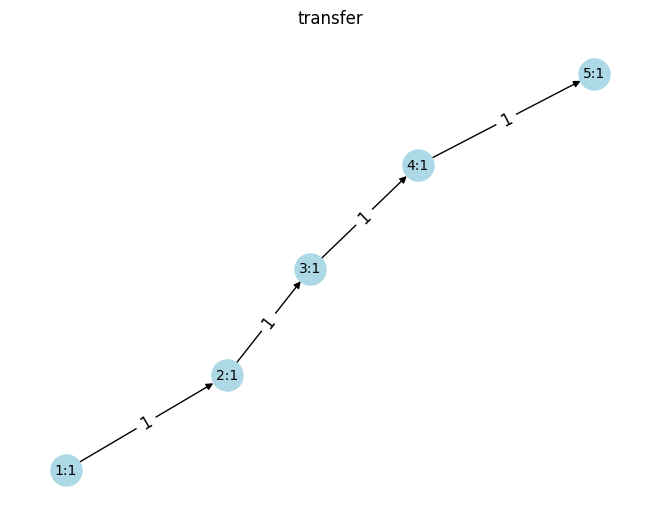

In [54]:
data = [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

<class 'list'>
[[DialogueMessage(text='Hey there! How can I help you today?', participant='assistant'), DialogueMessage(text='I need to book a ride to the airport.', participant='user'), DialogueMessage(text='Sure! I can help with that. When is your flight, and where are you departing from?', participant='assistant'), DialogueMessage(text='Do you have any other options?', participant='user'), DialogueMessage(text="If you'd prefer, I can send you options for ride-share services instead. Would you like that?", participant='assistant'), DialogueMessage(text='Actually, never mind.', participant='user'), DialogueMessage(text='Alright, let me know if you need help later. Have a great day!', participant='assistant'), DialogueMessage(text='Okay, have a great day!', participant='user'), DialogueMessage(text='Glad to help! Safe travels.', participant='assistant')], [DialogueMessage(text='Hey there! How can I help you today?', participant='assistant'), DialogueMessage(text='I need to book a ride 

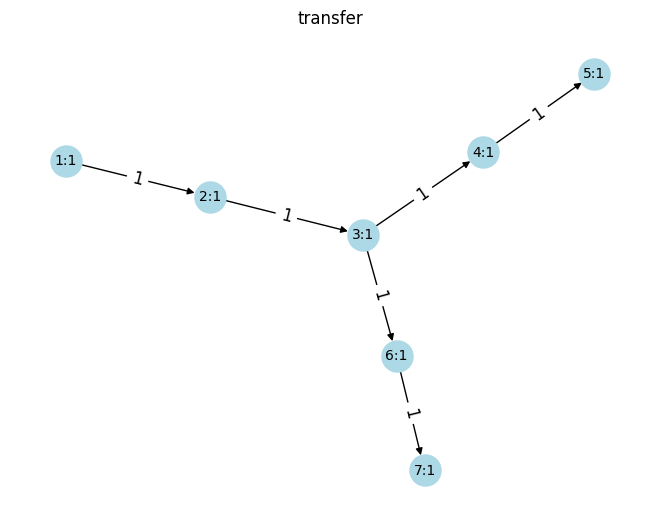

In [55]:
data = [[{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': 'Actually, never mind.', 'participant': 'user'},
   {'text': 'Alright, let me know if you need help later. Have a great day!',
    'participant': 'assistant'},
   {'text': 'Okay, have a great day!', 'participant': 'user'},
   {'text': 'Glad to help! Safe travels.', 'participant': 'assistant'}],
   [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

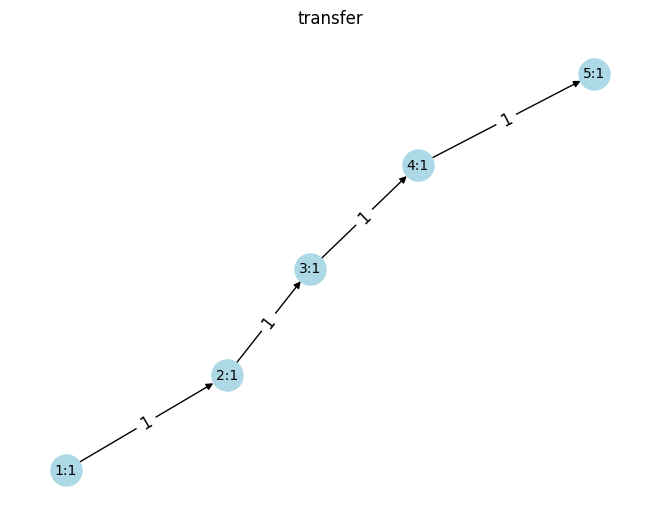

In [59]:
data = [{"messages": [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [22]:
data

{'graph': {'edges': [{'source': 1,
    'target': 2,
    'utterances': ['I need to book a ride to the airport.',
     'Can you help me arrange an airport transfer?']},
   {'source': 2,
    'target': 3,
    'utterances': ['My flight is on Saturday at 10 AM from JFK.',
     'Departure is from LAX tomorrow at 6 PM.']},
   {'source': 3,
    'target': 4,
    'utterances': ['Pickup is from my home in Brooklyn.',
     "I'd like to be picked up from my hotel."]},
   {'source': 4,
    'target': 5,
    'utterances': ["It's just me traveling.", 'There will be three of us.']},
   {'source': 5,
    'target': 6,
    'utterances': ['A sedan would be fine.',
     'I think an SUV would be more comfortable.']},
   {'source': 5,
    'target': 8,
    'utterances': ['Actually, can I change my vehicle type?',
     'Wait, I think I need a bigger car.']},
   {'source': 8,
    'target': 6,
    'utterances': ['A van would be better.', "I'll go with an SUV instead."]},
   {'source': 3,
    'target': 7,
    'utter

In [42]:
graph.graph_dict

{'nodes': [{'id': 1,
   'label': '',
   'is_start': True,
   'utterances': ['Welcome to our coffee shop, what would you like?']},
  {'id': 2,
   'label': '',
   'is_start': False,
   'utterances': ['Which tea would you like?']},
  {'id': 3,
   'label': '',
   'is_start': False,
   'utterances': ['Sorry, but we are out of green tea at the moment']},
  {'id': 4,
   'label': '',
   'is_start': False,
   'utterances': ['Which coffee would you like?']},
  {'id': 5,
   'label': '',
   'is_start': False,
   'utterances': ['Would you need a glass of water?']},
  {'id': 6,
   'label': '',
   'is_start': False,
   'utterances': ['Do you need any syrup?']},
  {'id': 7,
   'label': '',
   'is_start': False,
   'utterances': ['Here or takeaway?']},
  {'id': 8,
   'label': '',
   'is_start': False,
   'utterances': ['Do you need lactoze-free milk?']},
  {'id': 9,
   'label': '',
   'is_start': False,
   'utterances': ['Tea bags or loose tea?']}],
 'edges': [{'source': 1, 'target': 2, 'utterances': [

In [38]:
gr = Graph(data['true_graph'])
gr.graph_dict

{'edges': [{'utterances': ['Coffee'], 'source': 1, 'target': 2},
  {'utterances': ['Tea'], 'source': 1, 'target': 3},
  {'utterances': ['Espresso'], 'source': 2, 'target': 5},
  {'utterances': ['Latte'], 'source': 2, 'target': 4},
  {'utterances': ['Latte tea'], 'source': 3, 'target': 4},
  {'utterances': ['Green tea'], 'source': 3, 'target': 7},
  {'utterances': ['Black tea'], 'source': 3, 'target': 8},
  {'utterances': ['Yes'], 'source': 4, 'target': 6},
  {'utterances': ['Yes'], 'source': 5, 'target': 6},
  {'utterances': ['No, thanks'], 'source': 6, 'target': 9},
  {'utterances': ['Tea bags please'], 'source': 8, 'target': 9},
  {'utterances': ['Can you help me?'], 'source': 9, 'target': 1},
  {'utterances': ['Can you help me?'], 'source': 7, 'target': 1}],
 'nodes': [{'id': 1,
   'label': 'start',
   'is_start': True,
   'utterances': ['Welcome to our coffee shop, what would you like?']},
  {'id': 2,
   'label': '',
   'is_start': False,
   'utterances': ['Which coffee would you l

In [47]:
report

PipelineReport(service='d2g_light', properties={'time': 2.1800806522369385, 'simple_graph_comparison': True}, subreports=[{}])

In [26]:
graph.graph_dict

{'nodes': [{'id': 1,
   'label': '',
   'is_start': True,
   'utterances': ['Hey there! How can I help you today?']},
  {'id': 2,
   'label': '',
   'is_start': False,
   'utterances': ['Sure! I can help with that. When is your flight, and where are you departing from?']},
  {'id': 3,
   'label': '',
   'is_start': False,
   'utterances': ['Got it. Where should the driver pick you up?']},
  {'id': 4,
   'label': '',
   'is_start': False,
   'utterances': ['Thanks! How many passengers will be traveling?']},
  {'id': 5,
   'label': '',
   'is_start': False,
   'utterances': ['Alright! Do you have any preference for the type of vehicle? We have sedans, SUVs, and vans available.']},
  {'id': 6,
   'label': '',
   'is_start': False,
   'utterances': ['Of course! What type of vehicle would you prefer instead?']},
  {'id': 7,
   'label': '',
   'is_start': False,
   'utterances': ['All set! Your driver will arrive on time. Let me know if you need anything else.']},
  {'id': 8,
   'label': '',

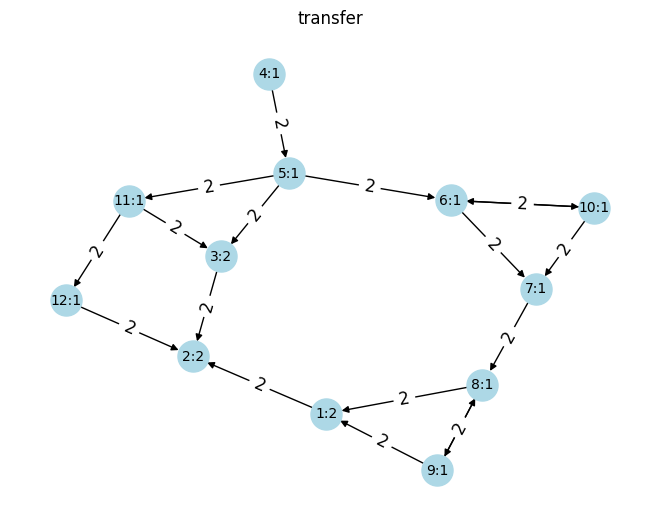

In [ ]:
with open('transfer_2.json') as f:
    data = json.load(f)

raw_data = PipelineRawDataType(dialogs=data['dialogs'])
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

VALI:  edges=[Edge(source=1, target=2, utterances=['I need to book a ride to the airport.', 'Can you help me arrange an airport transfer?']), Edge(source=2, target=3, utterances=['My flight is on Saturday at 10 AM from JFK.', 'Departure is from LAX tomorrow at 6 PM.']), Edge(source=3, target=4, utterances=['Pickup is from my home in Brooklyn.', "I'd like to be picked up from my hotel."]), Edge(source=4, target=5, utterances=["It's just me traveling.", 'There will be three of us.']), Edge(source=5, target=6, utterances=['A sedan would be fine.', 'I think an SUV would be more comfortable.']), Edge(source=5, target=8, utterances=['Actually, can I change my vehicle type?', 'Wait, I think I need a bigger car.']), Edge(source=8, target=6, utterances=['A van would be better.', "I'll go with an SUV instead."]), Edge(source=3, target=7, utterances=['Actually, I need to change my pickup location.', 'Hold on, pickup should be from my office instead.']), Edge(source=7, target=4, utterances=['Picku

INFO:dialogue2graph.metrics.no_llm_metrics.metrics:Graph has all the dialogues


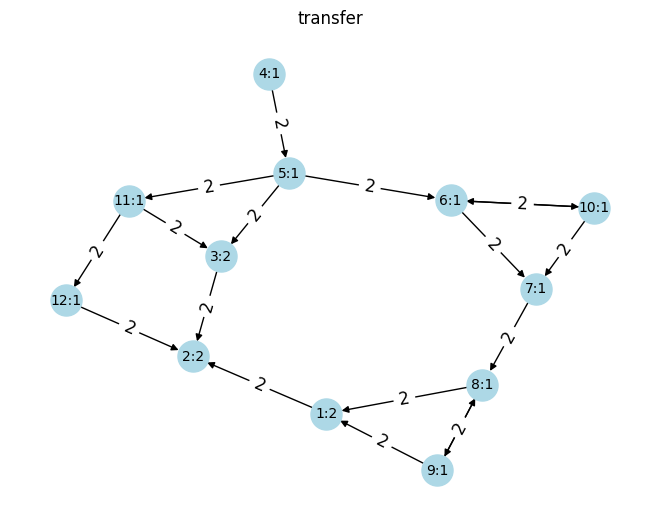

In [38]:
with open('transfer_2.json') as f:
    data = json.load(f)

raw_data = PipelineRawDataType(dialogs=data['dialogs'], true_graph=data['true_graph'])
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [36]:
report

PipelineReport(service='d2g_light', properties={'time': 35.30027651786804, 'simple_graph_comparison': False}, subreports=[{}])

INFO:dialogue2graph.metrics.no_llm_metrics.metrics:Graph has all the dialogues


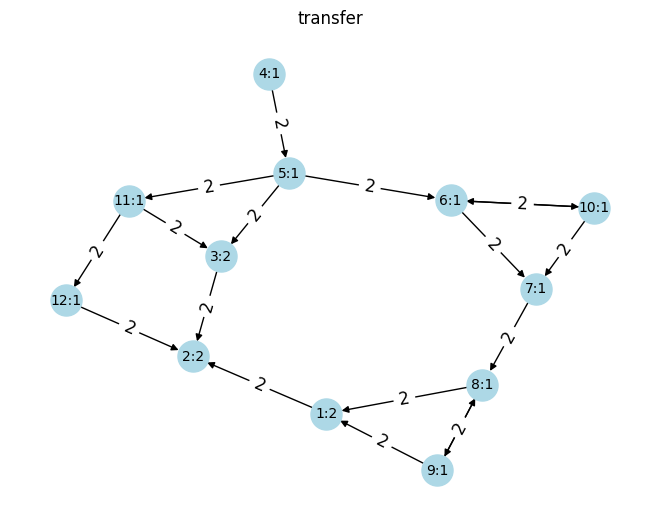

In [63]:
raw_data = PipelineRawDataType(dialogs='transfer_2.json', true_graph='transfer_2.json')
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [24]:
report

PipelineReport(service='d2g_light', properties={'time': 37.24576377868652, 'simple_graph_comparison': True}, subreports=[{}])

PAIRS:  [(6, 9), (7, 8), (12, 13)]
CUR:  [(6, 9), (7, 8), (12, 13)]


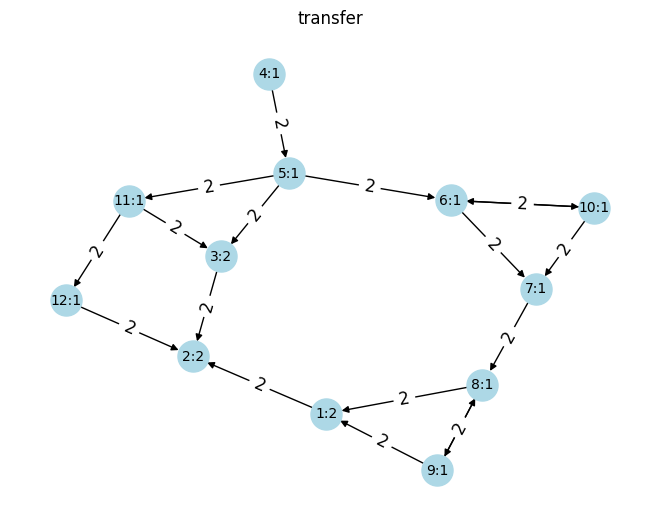

In [25]:
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

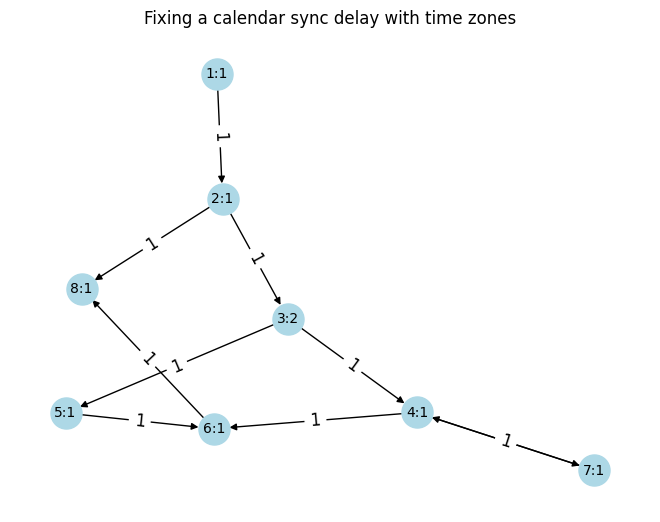

In [9]:
with open("test_graph_1.json", encoding="utf-8") as f:
    data = json.load(f)
Graph(data['true_graph']).visualise_short("Fixing a calendar sync delay with time zones")

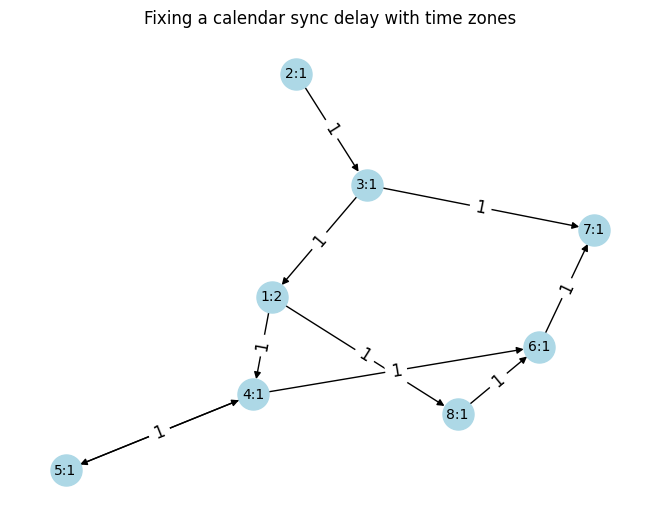

In [15]:
raw_data = PipelineRawDataType(dialogs="test_graph_1.json")
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("Fixing a calendar sync delay with time zones")

In [10]:
raw_data = PipelineRawDataType(dialogs=data['dialogs'], true_graph=data['true_graph'])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


PAIRS:  [(2, 7)]
CUR:  [(2, 7)]


INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:dialogue2graph.metrics.no_llm_metrics.metrics:Graph has all the dialogues


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PipelineReport(service='d2g_light', properties={'time': 8.57738184928894, 'simple_graph_comparison': True, 'complex_graph_comparison': {'value': True, 'description': 'Nodes similarity: 0.9999998807907104, Nodes+edges similarity: 0.9870117902755737'}}, subreports=[{'compare_graphs:step2': {'value': True, 'description': 'Nodes similarity: 0.9999998807907104, Nodes+edges similarity: 0.9870117902755737'}, 'is_same_structure:step2': True}])

### D2G LLM pipeline

In [64]:
from dialogue2graph.pipelines.d2g_llm.pipeline import D2GLLMPipeline
pipeline = D2GLLMPipeline(
        name="d2g_llm",
        model_storage=ms,
        grouping_llm="grouping_llm",
        filling_llm="filling_llm",
        formatting_llm="formatting_llm",
        sim_model="sim_model",
        step2_evals=metrics.DGEvalBase,
        end_evals=metrics.DGEvalBase
        )

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


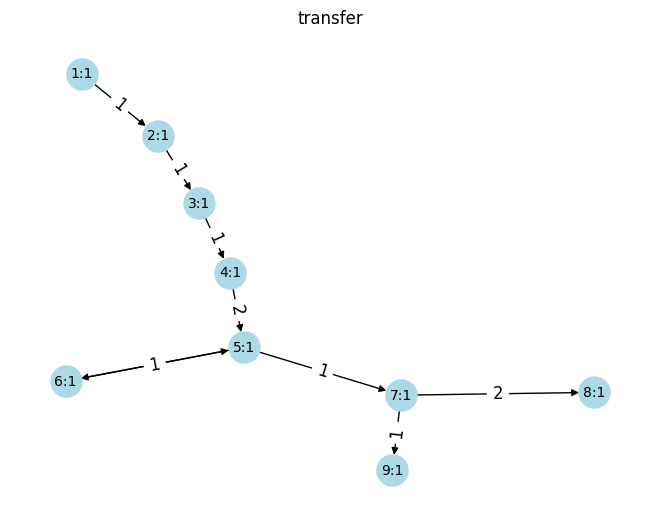

In [28]:
raw_data = PipelineRawDataType(dialogs='transfer.json')
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [[{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': 'Actually, never mind.', 'participant': 'user'},
   {'text': 'Alright, let me know if you need help later. Have a great day!',
    'participant': 'assistant'},
   {'text': 'Okay, have a great day!', 'participant': 'user'},
   {'text': 'Glad to help! Safe travels.', 'participant': 'assistant'}],
   [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [{"messages": [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
with open('transfer.json') as f:
    data = json.load(f)
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [1]:
with open("test_graph_1.json", encoding="utf-8") as f:
    data = json.load(f)
raw_data = PipelineRawDataType(dialogs=data['dialogs'], true_graph=data['true_graph'])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

NameError: name 'json' is not defined

### D2G LLM extender

In [65]:
from dialogue2graph.pipelines.d2g_extender.pipeline import D2GExtenderPipeline
pipeline = D2GExtenderPipeline(
        name="d2g_ext",
        model_storage=ms,
        extending_llm="extending_llm",
        filling_llm="filling_llm",
        formatting_llm="formatting_llm",
        sim_model="sim_model",
        step1_evals=metrics.PreDGEvalBase,
        extender_evals=metrics.PreDGEvalBase,
        step2_evals=metrics.DGEvalBase,
        end_evals=metrics.DGEvalBase
        )

INFO:dialogue2graph.pipelines.model_storage:Added llm model 'd2g_extender_dialog_llm:v1' to storage


INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


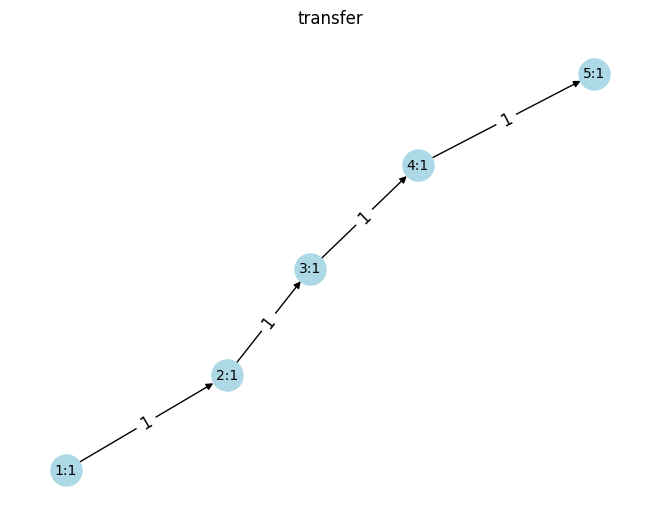

In [8]:
data = [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [[{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': 'Actually, never mind.', 'participant': 'user'},
   {'text': 'Alright, let me know if you need help later. Have a great day!',
    'participant': 'assistant'},
   {'text': 'Okay, have a great day!', 'participant': 'user'},
   {'text': 'Glad to help! Safe travels.', 'participant': 'assistant'}]]
raw_data = PipelineRawDataType(dialogs=data, supported_graph=graph.graph_dict)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [{"messages": [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

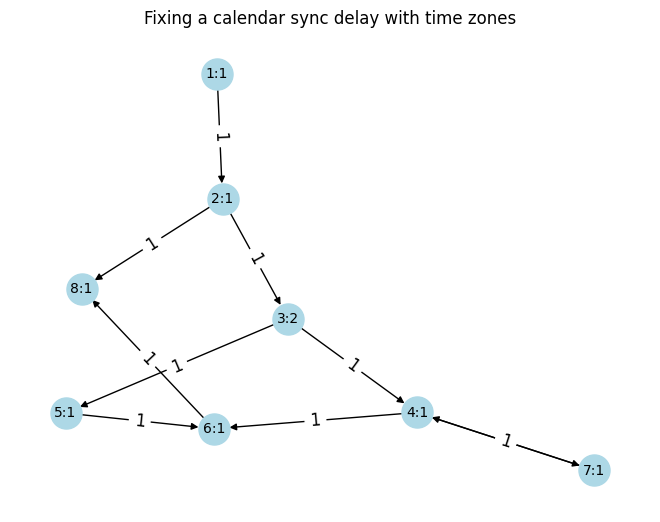

In [48]:
with open("test_graph_1.json", encoding="utf-8") as f:
    data = json.load(f)
Graph(data['true_graph']).visualise_short("Fixing a calendar sync delay with time zones")

In [49]:
raw_data = PipelineRawDataType(dialogs=data['dialogs'], true_graph=data['true_graph'])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
ERROR:dialogue2graph.pipelines.d2g_extender.three_stages_extender:Error in dialog sampler: unhashable type: 'list'


AttributeError: 'NoneType' object has no attribute 'is_directed'

In [50]:
with open("test_metrics_data.json", encoding="utf-8") as f:
    data_2 = json.load(f)

In [ ]:
data_2[2]

In [51]:
raw_data = PipelineRawDataType(dialogs=data_2[2]['dialogues'], true_graph=data['true_graph'])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
ERROR:dialogue2graph.pipelines.d2g_extender.three_stages_extender:Error in dialog sampler: unhashable type: 'list'


AttributeError: 'NoneType' object has no attribute 'is_directed'